I. Set Up

In [31]:
# PYTHON Imports 
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import math
import statistics
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pathlib import Path
import glob
import ipywidgets as widgets
from IPython.display import clear_output
import sys
import time
import json
# ASTROPHY Imports
import astropy 
from astropy.table import Table
from astropy.io import fits
from sherpa.astro import ui
# CIAO Imports
import ciao_contrib.runtool
from ciao_contrib.runtool import *
# CUSTOM Imports
from data_exploration_functions import *
from data_representation_functions import *

# Specify global path
global_path = '/Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets'
global_folders = list_folders_fun(global_path)

# Select dataset
set_widget = widgets.Dropdown(options=global_folders[:],value=global_folders[1],description='Set :',disabled=False); set_widget

Dropdown(description='Set :', index=1, options=('All', 'Bona'), value='Bona')

II. Load Data

In [32]:
# Set ID
set_id = set_widget.value
# Load eventfiles and properties
df_eventfiles_input = pd.read_csv(f'{global_path}/{set_id}/eventfiles-input-{set_id}.csv')
df_properties_input = pd.read_csv(f'{global_path}/{set_id}/properties-input-{set_id}.csv')
# Group eventfiles and properties
df_eventfiles_group = df_eventfiles_input.groupby('obsreg_id')
df_properties_group = df_properties_input.groupby('obsreg_id')
# Filter eventfiles and properties 
df_eventfiles_group = df_eventfiles_group.filter(lambda x: len(x) > 49).groupby('obsreg_id')
keep_obsreg = list(df_eventfiles_group.groups.keys())
df_properties_group = df_properties_group.filter(lambda x: x.name in keep_obsreg).groupby('obsreg_id')
# Print eventfiles and properties number of IDs
print("Number of Eventfiles: ", df_eventfiles_group.ngroups)
print("Number of Property Sets: ", df_properties_group.ngroups)


Number of Eventfiles:  62989
Number of Property Sets:  62989


III. Create features

In [33]:
# Initialise dictionary lists
feature_list = []
id_list = []
# Initialise counters
count = 0
count_limit = df_eventfiles_group.ngroups
# Binning Settings
nbins_E = 20
nbins_t = 25

def hist2D_Et(df_eventfile_input, id_name, nbins_E, nbins_t,normalise = True):
    # Copy df
    df = df_eventfile_input.copy()
    # Define histogram boundaries
    E_start = np.log10(500)
    E_end = np.log10(7000)
    t_start = 0
    t_end = 1
    # IDs
    obsid = id_name.split("_")[0]
    regid = id_name.split("_")[1]
    # Eventfile length and duration
    N_length = len(df) 
    T_duration = max(df["time"])-min(df["time"])
    # Add E, t column
    df["E"] = np.log10(df["energy"])
    df["t"] = (df["time"]-min(df["time"]))/(max(df["time"])-min(df["time"]))
    # Add Et histogram
    hist_Et = plt.hist2d(df["t"],df["E"],range = [[t_start,t_end],[E_start, E_start]],bins=(nbins_t,nbins_E),norm=LogNorm(),cmap = 'plasma') 
    if normalise == True:
        feature = hist_Et[0]/np.max(hist_Et[0])
    else:
        feature = hist_Et[0]
    return feature

DONE!!!


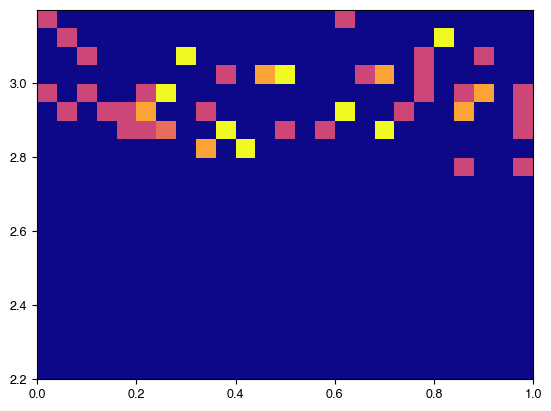

In [34]:
all_ids = list(df_eventfiles_group.groups.keys())
keep_obsreg = all_ids #31000
df_eventfiles_group_filtered = df_eventfiles_group.filter(lambda x: x.name in keep_obsreg).groupby('obsreg_id')
ex = ['10871_10','13814_567','9109_333','10995_21','10285_653','10098_46'] # ['10871_10','13814_567','15267_38','11016_168','1690_2']
#df_eventfiles_group_filtered = df_eventfiles_group.filter(lambda x: x.name in ex).groupby('obsreg_id')

for id_name, dfi in df_eventfiles_group_filtered:
    id_list.append(id_name)
    #lc_plotter_fun(dfi,id_name,100)
    #fig,axs=plt.subplots(1,3,figsize=(12,2),constrained_layout = True)
    #plt.subplot(1, 3, 1)
    feature_list.append(hist2D_Et(dfi, id_name, nbins_E, nbins_t,normalise = True))
    count = count+1
    print(f'Counter: {count} of {count_limit}')
    clear_output(wait=True)

hist_dict = dict(zip(id_list, feature_list))
print(f'DONE!!!')
    #plt.show()


In [35]:
hist_dict = dict(zip(id_list, feature_list))
with open(f'{global_path}/{set_id}/histEt-{set_id}-nE{nbins_E}-nt{nbins_t}.csv', 'w') as f:
    json.dump(hist_dict, f)


TypeError: Object of type ndarray is not JSON serializable